In [1]:
# Importing Pandas and NumPy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
## to suppress warnings
import warnings
warnings.filterwarnings('ignore')

## to suppress output status
from IPython.utils import io

## to print all statement in single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data display customization
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [3]:
# Module for feature scaling
from sklearn.preprocessing import StandardScaler

# Module for Train Test split
from sklearn.model_selection import train_test_split

# Module for Logistic regression model
import statsmodels.api as sm

# Module for RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Module for confusion matrix
from sklearn import metrics

# Module to check the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Module to check precision and recall score and curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

# Module to build classification report
from sklearn.metrics import classification_report

In [4]:
### define all reusable functions

# Countplot function
def func_countplot(col,df):
    fig, ax1 = plt.subplots(figsize=(12,8))
    graph = sns.barplot(x = df[col].value_counts(ascending = False).keys(), y = df[col].value_counts(ascending = False) )
    graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
    for p in graph.patches:
        height = p.get_height()
        graph.text(p.get_x()+p.get_width()/2., height + 15,height ,ha="center")

#Function to plot a list of categorical variables together
def func_boxplot(var_list,df):
    plt.figure(figsize=(22, 18))
    for var in var_list:
        plt.subplot(4,4,var_list.index(var)+1)
        sns.boxplot(y = var, data = df)
    plt.show()
    
# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# To calculate the VIF
def func_VIF(X_train):
    vif = pd.DataFrame()
    X = X_train
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

# To get area under curve in ROC plot

def func_auc(fpr,tpr):
    AreaUnderCurve = 0.
    for i in range(len(fpr)-1):
        AreaUnderCurve += (fpr[i+1]-fpr[i]) * (tpr[i+1]+tpr[i])
    AreaUnderCurve *= 0.5
    return AreaUnderCurve

### Step 1: Importing and understanding data 

In [5]:
#reading Dataset
df_rawdata = pd.read_csv("Analysis.csv",  sep = ',',encoding = "ISO-8859-1")
df_rawdata.head()

STUDENT_ID EnrollmentTerm EnrollmentTerm_StartDate  \
0        2207           16T1               12/14/2015   
1        1176           15T4                7/13/2015   
2        3647           16T3                5/23/2016   
3        9507           15T5                9/28/2015   
4        7983           15T4                7/13/2015   

   fye_retention_term_seq_1  fye_retention_term_seq_2  \
0                         1                         1   
1                         1                         1   
2                         1                         1   
3                         1                         1   
4                         1                         0   

   fye_retention_term_seq_3  fye_retention_term_seq_4  \
0                         1                         1   
1                         1                         1   
2                         1                         1   
3                         1                         1   
4                         0                         0   

   fye_retention_term_seq_5  fye_retention_term_seq_6  \
0                         1                         1   
1                         1                         1   
2                         1                         1   
3                         1                         1   
4                         0                         0   

  fye_prtcpt_in_fye_1_2_3_4_5  fye_debt_prior_Univ  fye_Univ_debt  \
0                     MISSING                    0            0.0   
1                     MISSING                    0            0.0   
2                         Yes                77800        32800.0   
3                     MISSING                    0            0.0   
4                     MISSING                    0         2908.0   

   fye_success_term_seq_1  dmgy_military_flag_1_2_3_4_5  \
0                       0                             0   
1                       1                             0   
2                       1                             0   
3                       1                             0   
4                       0                             0   

  dmgy_ethnicity_1_2_3_4_5 dmgy_gender_1_2_3_4_5 dmgy_region_1_2_3_4_5  \
0                    White                     M                   NE3   
1                    White                     M              Mountain   
2                    White                     F                   NE3   
3                    White                     F                   NE3   
4                    White                     M             Southeast   

  dmgy_state_1_2_3_4_5  dmgy_age_1_2_3_4_5  Change Major Term  \
0                   MA                  45                NaN   
1                   AZ                  59                4.0   
2                   NH                  53                NaN   
3                   NH                  40                NaN   
4                   SC                  68                NaN   

   mdl_transfer_credits_1_2_3_4_5 mdl_lead_medium_type_1_2_3_4_5  \
0                               0                       pdsearch   
1                               0                        Organic   
2                               0                          Other   
3                               0                        Organic   
4                               0                          Other   

   mdl_student_famcontribution_1_2_3_4_5 mdl_prv_ug_gpa_bins_1_2_3_4_5  \
0                                    999                       Missing   
1                                    999                       Missing   
2                                   2199                       Missing   
3                                    999                       Missing   
4                                  17994                       Missing   

   mdl_prv_ug_grad_Univ_1_2_3_4_5 mdl_email_domain_1_2_3_4_5  \
0                               1                  CORPORATE   
1                               1          

In [6]:
df_rawdata.shape

df_rawdata.info()

(10433, 180)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10433 entries, 0 to 10432
Columns: 180 entries, STUDENT_ID to ods_programs_avg_gpa
dtypes: float64(125), int64(30), object(25)
memory usage: 14.3+ MB


### Step 2: Data Cleaning and manipulation

In [7]:
## check for duplicates for Prospect Id :A unique ID with which the customer is identified.

sum(df_rawdata.duplicated(subset = 'STUDENT_ID'))

0

In [8]:
## check for unique values ,if there is any column with single value, then it won't be much help in prediction

df_rawdata.nunique().sort_values()

fye_retention_term_seq_1                           1
enrl_course_retake_count_term_seq_1                1
fye_success_term_seq_1                             2
aep_flag_term_seq_1                                2
fye_retention_term_seq_2                           2
fye_retention_term_seq_3                           2
fye_retention_term_seq_4                           2
fye_retention_term_seq_5                           2
fye_retention_term_seq_6                           2
dmgy_gender_1_2_3_4_5                              2
mdl_prv_ug_grad_Univ_1_2_3_4_5                     2
dmgy_military_flag_1_2_3_4_5                       2
enrl_course_retake_count_term_seq_2                3
enrl_course_retake_count_term_seq_3                3
enrl_course_retake_count_term_seq_5                3
enrl_course_retake_count_term_seq_4                3
fye_prtcpt_in_fye_1_2_3_4_5                        3
enrl_course_success_count_term_seq_1               4
enrl_course_count_term_seq_1                  

#### Observation : below columns have single value . We can drop those columns

1. fye_retention_term_seq_1                           
                  

In [9]:
df_rawdata['fye_retention_term_seq_1'].unique()

array([1], dtype=int64)

In [10]:
print("Size before dropping columns")
df_rawdata.shape

df_rawdata = df_rawdata.loc[:,df_rawdata.nunique()!=1]

print("Size after dropping columns")
df_rawdata.shape

Size before dropping columns


(10433, 180)

Size after dropping columns


(10433, 178)

In [11]:
## Null handling : a) any columns with all null values

df_rawdata.isnull().sum().sort_values(ascending=False)



cl_avg_time_bw_cmpltd_calls_term_seq_5         9273
Change Major Term                              9236
cl_avg_time_bw_cmpltd_calls_term_seq_4         8768
cl_avg_time_bw_cmpltd_calls_term_seq_3         8075
cl_avg_time_bw_cmpltd_calls_term_seq_2         7682
cl_avg_time_bw_cmpltd_calls_term_seq_1         6073
cl_tot_calls_term_seq_5                        4353
cl_tot_cmpltd_calls_term_seq_5                 4353
cl_overall_eng_rate_term_seq_5                 4353
cl_tot_inbound_calls_term_seq_5                4353
enrl_course_success_count_term_seq_5           4129
enrl_course_retake_count_term_seq_5            4129
asn_prct_late_count_term_seq_5                 4125
asn_prct_early_count_term_seq_5                4125
asn_prct_high_stakes_late_count_term_seq_5     4125
asn_avg_tot_grade_attempted_term_seq_5         4125
asn_prct_high_stakes_early_count_term_seq_5    4125
cl_tot_calls_term_seq_4                        3953
cl_tot_inbound_calls_term_seq_4                3953
cl_overall_e

In [12]:
## b) any rows with all null values

df_rawdata[df_rawdata.isnull().all(1)] 

Empty DataFrame
Columns: [STUDENT_ID, EnrollmentTerm, EnrollmentTerm_StartDate, fye_retention_term_seq_2, fye_retention_term_seq_3, fye_retention_term_seq_4, fye_retention_term_seq_5, fye_retention_term_seq_6, fye_prtcpt_in_fye_1_2_3_4_5, fye_debt_prior_Univ, fye_Univ_debt, fye_success_term_seq_1, dmgy_military_flag_1_2_3_4_5, dmgy_ethnicity_1_2_3_4_5, dmgy_gender_1_2_3_4_5, dmgy_region_1_2_3_4_5, dmgy_state_1_2_3_4_5, dmgy_age_1_2_3_4_5, Change Major Term, mdl_transfer_credits_1_2_3_4_5, mdl_lead_medium_type_1_2_3_4_5, mdl_student_famcontribution_1_2_3_4_5, mdl_prv_ug_gpa_bins_1_2_3_4_5, mdl_prv_ug_grad_Univ_1_2_3_4_5, mdl_email_domain_1_2_3_4_5, aep_flag_term_seq_1, enrl_course_count_term_seq_1, enrl_course_count_term_seq_2, enrl_course_count_term_seq_3, enrl_course_count_term_seq_4, enrl_course_count_term_seq_5, enrl_course_success_count_term_seq_1, enrl_course_success_count_term_seq_2, enrl_course_success_count_term_seq_3, enrl_course_success_count_term_seq_4, enrl_course_success_count_term_seq_5, enrl_course_retake_count_term_seq_2, enrl_course_retake_count_term_seq_3, enrl_course_retake_count_term_seq_4, enrl_course_retake_count_term_seq_5, cl_tot_calls_term_seq_1, cl_tot_calls_term_seq_2, cl_tot_calls_term_seq_3, cl_tot_calls_term_seq_4, cl_tot_calls_term_seq_5, cl_tot_cmpltd_calls_term_seq_1, cl_tot_cmpltd_calls_term_seq_2, cl_tot_cmpltd_calls_term_seq_3, cl_tot_cmpltd_calls_term_seq_4, cl_tot_cmpltd_calls_term_seq_5, cl_overall_eng_rate_term_seq_1, cl_overall_eng_rate_term_seq_2, cl_overall_eng_rate_term_seq_3, cl_overall_eng_rate_term_seq_4, cl_overall_eng_rate_term_seq_5, cl_tot_inbound_calls_term_seq_1, cl_tot_inbound_calls_term_seq_2, cl_tot_inbound_calls_term_seq_3, cl_tot_inbound_calls_term_seq_4, cl_tot_inbound_calls_term_seq_5, cl_avg_time_bw_cmpltd_calls_term_seq_1, cl_avg_time_bw_cmpltd_calls_term_seq_2, cl_avg_time_bw_cmpltd_calls_term_seq_3, cl_avg_time_bw_cmpltd_calls_term_seq_4, cl_avg_time_bw_cmpltd_calls_term_seq_5, cl_gpa_bins_term_seq_1, cl_gpa_bins_term_seq_2, cl_gpa_bins_term_seq_3, cl_gpa_bins_term_seq_4, cl_gpa_bins_term_seq_5, asn_prct_late_count_term_seq_1, asn_prct_late_count_term_seq_2, asn_prct_late_count_term_seq_3, asn_prct_late_count_term_seq_4, asn_prct_late_count_term_seq_5, asn_prct_early_count_term_seq_1, asn_prct_early_count_term_seq_2, asn_prct_early_count_term_seq_3, asn_prct_early_count_term_seq_4, asn_prct_early_count_term_seq_5, asn_prct_high_stakes_late_count_term_seq_1, asn_prct_high_stakes_late_count_term_seq_2, asn_prct_high_stakes_late_count_term_seq_3, asn_prct_high_stakes_late_count_term_seq_4, asn_prct_high_stakes_late_count_term_seq_5, asn_prct_high_stakes_early_count_term_seq_1, asn_prct_high_stakes_early_count_term_seq_2, asn_prct_high_stakes_early_count_term_seq_3, asn_prct_high_stakes_early_count_term_seq_4, asn_prct_high_stakes_early_count_term_seq_5, asn_avg_tot_grade_attempted_term_seq_1, asn_avg_tot_grade_attempted_term_seq_2, asn_avg_tot_grade_attempted_term_seq_3, asn_avg_tot_grade_attempted_term_seq_4, asn_avg_tot_grade_attempted_term_seq_5, blk_tot_sessions_term_seq_1, blk_tot_sessions_term_seq_2, blk_tot_sessions_term_seq_3, blk_tot_sessions_term_seq_4, blk_tot_sessions_term_seq_5, ...]
Index: []

In [13]:
## drop rows more than 25 missing values

df_rawdata[df_rawdata.isnull().sum(axis=1)>25]

STUDENT_ID EnrollmentTerm EnrollmentTerm_StartDate  \
0            2207           16T1               12/14/2015   
1            1176           15T4                7/13/2015   
3            9507           15T5                9/28/2015   
4            7983           15T4                7/13/2015   
5             905           16T1               12/14/2015   
10           4822           16T2               03-07-2016   
13           6708           15T5                9/28/2015   
18           1027           15T4                7/13/2015   
20           6183           15T4                7/13/2015   
21           4420           15T4                7/13/2015   
22           5266           15T4                7/13/2015   
23           5786           15T5                9/28/2015   
25           8638           15T5                9/28/2015   
30           6554           16T2               03-07-2016   
34           4970           16T2               03-07-2016   
35           7801           15T5                9/28/2015   
38          10393           16T1               12/14/2015   
39          10602           15T4                7/13/2015   
41            540           16T2               03-07-2016   
42            708           15T5                9/28/2015   
43           5068           16T2               03-07-2016   
45           7609           15T5                9/28/2015   
46          10252           16T2               03-07-2016   
47           5679           16T2               03-07-2016   
49           4558           16T3                5/23/2016   
50           8791           16T3                5/23/2016   
51           8876           16T3                5/23/2016   
54           9598           16T2               03-07-2016   
56           4884           15T5                9/28/2015   
57           3582           15T5                9/28/2015   
59           5523           16T1               12/14/2015   
61           5584           16T1               12/14/2015   
62           7646           16T2               03-07-2016   
63           6336           16T3                5/23/2016   
64           2244           16T3                5/23/2016   
69           6437           16T2               03-07-2016   
70           4130           16T1               12/14/2015   
74            659           15T5                9/28/2015   
77           5056           15T5                9/28/2015   
79           5362           15T4                7/13/2015   
86           4919           16T3                5/23/2016   
87           5852           16T1               12/14/2015   
88           2784           16T1               12/14/2015   
89           9688           15T5                9/28/2015   
91           6903           16T1               12/14/2015   
92           6433           15T4                7/13/2015   
97           6499           15T5                9/28/2015   
99           5223           16T1               12/14/2015   
100           897           16T3                5/23/2016   
105          3522           16T2               03-07-2016   
106          9987           15T5                9/28/2015   
107          2757           15T4                7/13/2015   
108          1864           15T5                9/28/2015   
111          3703           16T2               03-07-2016   
112           436           16T2               03-07-2016   
113           583           16T2               03-07-2016   
117          8329           16T1               12/14/2015   
118          2435           16T1               12/14/2015   
120          4613           16T2               03-07-2016   
123           563           15T5                9/28/2015   
125          3183           16T2               03-07-2016   
126          9265           16T1               12/14/2015   
128          7125           16T3                5/23/2016   
133          6851           16T3                5/23/2016   
140          1525           16T3          

#### Observations :  There is no columns or rows with all null values.

In [14]:
## check percentage of nulls

round(100*(df_rawdata.isnull().sum()/len(df_rawdata)),2).sort_values(ascending=False)

cl_avg_time_bw_cmpltd_calls_term_seq_5         88.88
Change Major Term                              88.53
cl_avg_time_bw_cmpltd_calls_term_seq_4         84.04
cl_avg_time_bw_cmpltd_calls_term_seq_3         77.40
cl_avg_time_bw_cmpltd_calls_term_seq_2         73.63
cl_avg_time_bw_cmpltd_calls_term_seq_1         58.21
cl_tot_calls_term_seq_5                        41.72
cl_tot_cmpltd_calls_term_seq_5                 41.72
cl_overall_eng_rate_term_seq_5                 41.72
cl_tot_inbound_calls_term_seq_5                41.72
enrl_course_success_count_term_seq_5           39.58
enrl_course_retake_count_term_seq_5            39.58
asn_prct_late_count_term_seq_5                 39.54
asn_prct_early_count_term_seq_5                39.54
asn_prct_high_stakes_late_count_term_seq_5     39.54
asn_avg_tot_grade_attempted_term_seq_5         39.54
asn_prct_high_stakes_early_count_term_seq_5    39.54
cl_tot_calls_term_seq_4                        37.89
cl_tot_inbound_calls_term_seq_4               

#### To avoid data loss, we will check columns with null one by one , then decide whether columns is required or not


In [15]:
## null handling for 'Change Major Term'
df_rawdata['Change Major Term'].isnull().sum()

df_rawdata['Change Major Term'].value_counts()

# fill null with Not sure as customer could not decide value from option.

df_rawdata['Change Major Term'].fillna("Not Sure", inplace = True)

df_rawdata['Change Major Term'].value_counts()

9236

1.0    269
3.0    245
2.0    228
4.0    165
5.0    149
6.0    141
Name: Change Major Term, dtype: int64

Not Sure    9236
1.0          269
3.0          245
2.0          228
4.0          165
5.0          149
6.0          141
Name: Change Major Term, dtype: int64

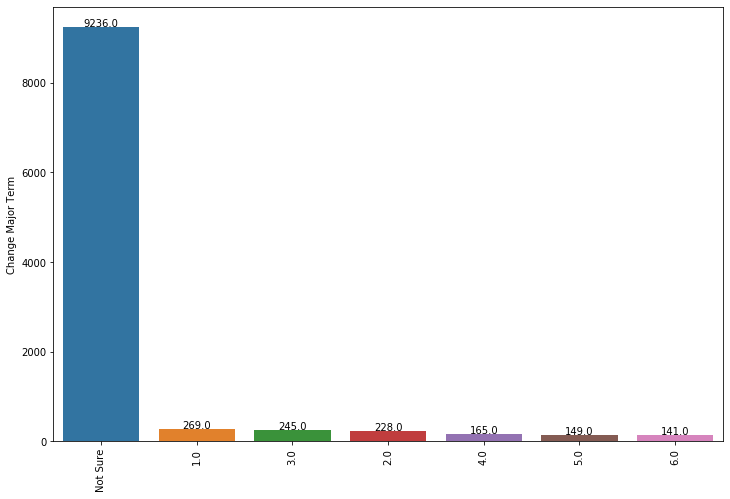

In [16]:
# countplot for Change Major Term

func_countplot('Change Major Term',df_rawdata)

In [17]:
## null handling for 'dmgy_region_1_2_3_4_5'
df_rawdata['dmgy_region_1_2_3_4_5'].isnull().sum()

df_rawdata['dmgy_region_1_2_3_4_5'].value_counts()

# fill null with Not sure as customer could not decide value from option.

df_rawdata['dmgy_region_1_2_3_4_5'].fillna("Not Sure", inplace = True)

df_rawdata['dmgy_region_1_2_3_4_5'].value_counts()

1

NE3             2290
Mid-Atlantic    1611
Gulf States     1503
Southeast       1426
Midwest          926
Pacific          863
Mid-South        578
NE4-6            533
Mountain         492
Plains           188
Military          18
Islands            4
Name: dmgy_region_1_2_3_4_5, dtype: int64

NE3             2290
Mid-Atlantic    1611
Gulf States     1503
Southeast       1426
Midwest          926
Pacific          863
Mid-South        578
NE4-6            533
Mountain         492
Plains           188
Military          18
Islands            4
Not Sure           1
Name: dmgy_region_1_2_3_4_5, dtype: int64

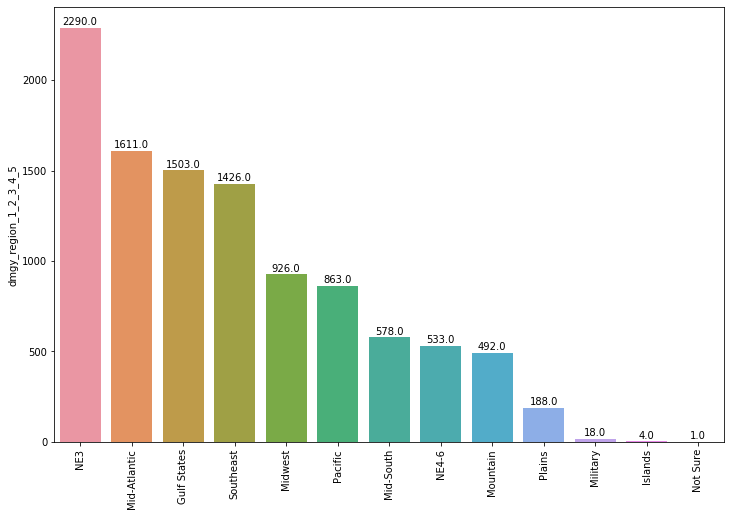

In [18]:
# countplot for dmgy_region_1_2_3_4_5

func_countplot('dmgy_region_1_2_3_4_5',df_rawdata)

In [19]:
df_rawdata.shape
df_rawdata.isnull().sum().sort_values(ascending=False)

(10433, 178)

cl_avg_time_bw_cmpltd_calls_term_seq_5         9273
cl_avg_time_bw_cmpltd_calls_term_seq_4         8768
cl_avg_time_bw_cmpltd_calls_term_seq_3         8075
cl_avg_time_bw_cmpltd_calls_term_seq_2         7682
cl_avg_time_bw_cmpltd_calls_term_seq_1         6073
cl_tot_calls_term_seq_5                        4353
cl_overall_eng_rate_term_seq_5                 4353
cl_tot_inbound_calls_term_seq_5                4353
cl_tot_cmpltd_calls_term_seq_5                 4353
enrl_course_success_count_term_seq_5           4129
enrl_course_retake_count_term_seq_5            4129
asn_prct_late_count_term_seq_5                 4125
asn_prct_early_count_term_seq_5                4125
asn_prct_high_stakes_late_count_term_seq_5     4125
asn_avg_tot_grade_attempted_term_seq_5         4125
asn_prct_high_stakes_early_count_term_seq_5    4125
cl_tot_calls_term_seq_4                        3953
cl_tot_inbound_calls_term_seq_4                3953
cl_overall_eng_rate_term_seq_4                 3953
cl_tot_cmplt

In [20]:
## Let check again if any column is not useful, we can drop

df_rawdata.head()

STUDENT_ID EnrollmentTerm EnrollmentTerm_StartDate  \
0        2207           16T1               12/14/2015   
1        1176           15T4                7/13/2015   
2        3647           16T3                5/23/2016   
3        9507           15T5                9/28/2015   
4        7983           15T4                7/13/2015   

   fye_retention_term_seq_2  fye_retention_term_seq_3  \
0                         1                         1   
1                         1                         1   
2                         1                         1   
3                         1                         1   
4                         0                         0   

   fye_retention_term_seq_4  fye_retention_term_seq_5  \
0                         1                         1   
1                         1                         1   
2                         1                         1   
3                         1                         1   
4                         0                         0   

   fye_retention_term_seq_6 fye_prtcpt_in_fye_1_2_3_4_5  fye_debt_prior_Univ  \
0                         1                     MISSING                    0   
1                         1                     MISSING                    0   
2                         1                         Yes                77800   
3                         1                     MISSING                    0   
4                         0                     MISSING                    0   

   fye_Univ_debt  fye_success_term_seq_1  dmgy_military_flag_1_2_3_4_5  \
0            0.0                       0                             0   
1            0.0                       1                             0   
2        32800.0                       1                             0   
3            0.0                       1                             0   
4         2908.0                       0                             0   

  dmgy_ethnicity_1_2_3_4_5 dmgy_gender_1_2_3_4_5 dmgy_region_1_2_3_4_5  \
0                    White                     M                   NE3   
1                    White                     M              Mountain   
2                    White                     F                   NE3   
3                    White                     F                   NE3   
4                    White                     M             Southeast   

  dmgy_state_1_2_3_4_5  dmgy_age_1_2_3_4_5 Change Major Term  \
0                   MA                  45          Not Sure   
1                   AZ                  59                 4   
2                   NH                  53          Not Sure   
3                   NH                  40          Not Sure   
4                   SC                  68          Not Sure   

   mdl_transfer_credits_1_2_3_4_5 mdl_lead_medium_type_1_2_3_4_5  \
0                               0                       pdsearch   
1                               0                        Organic   
2                               0                          Other   
3                               0                        Organic   
4                               0                          Other   

   mdl_student_famcontribution_1_2_3_4_5 mdl_prv_ug_gpa_bins_1_2_3_4_5  \
0                                    999                       Missing   
1                                    999                       Missing   
2                                   2199                       Missing   
3                                    999                       Missing   
4                                  17994                       Missing   

   mdl_prv_ug_grad_Univ_1_2_3_4_5 mdl_email_domain_1_2_3_4_5  \
0                               1                  CORPORATE   
1                               1                  CORPORATE   
2                               1                  CORPORATE   
3                               1                     OTHERS   
4                               1           

In [21]:
## STUDENT_ID are unique number assigned to students. It is more like indexing.
## drop for now


df_students = df_rawdata.drop(["STUDENT_ID"],axis=1)

df_students.shape

df_students.describe()

(10433, 177)

fye_retention_term_seq_2  fye_retention_term_seq_3  \
count              10433.000000              10433.000000   
mean                   0.885555                  0.817215   
std                    0.318366                  0.386509   
min                    0.000000                  0.000000   
25%                    1.000000                  1.000000   
50%                    1.000000                  1.000000   
75%                    1.000000                  1.000000   
max                    1.000000                  1.000000   

       fye_retention_term_seq_4  fye_retention_term_seq_5  \
count              10433.000000              10433.000000   
mean                   0.748107                  0.694910   
std                    0.434121                  0.460467   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    1.000000                  1.000000   
75%                    1.000000                  1.000000   
max                    1.000000                  1.000000   

       fye_retention_term_seq_6  fye_debt_prior_Univ  fye_Univ_debt  \
count              10433.000000         10433.000000   10433.000000   
mean                   0.660213         18314.136873   19682.395195   
std                    0.473660         25821.184651   18917.787373   
min                    0.000000             0.000000       0.000000   
25%                    0.000000             0.000000       0.000000   
50%                    1.000000             0.000000   16400.000000   
75%                    1.000000         31026.000000   32800.000000   
max                    1.000000        147109.000000  114969.000000   

       fye_success_term_seq_1  dmgy_military_flag_1_2_3_4_5  \
count            10433.000000                  10433.000000   
mean                 0.820473                      0.139749   
std                  0.383811                      0.346743   
min                  0.000000                      0.000000   
25%                  1.000000                      0.000000   
50%                  1.000000                      0.000000   
75%                  1.000000                      0.000000   
max                  1.000000                      1.000000   

       dmgy_age_1_2_3_4_5  mdl_transfer_credits_1_2_3_4_5  \
count        10433.000000                    10433.000000   
mean            33.514042                        0.003546   
std              9.599616                        0.124180   
min             17.000000                        0.000000   
25%             26.000000                        0.000000   
50%             31.000000                        0.000000   
75%             40.000000                        0.000000   
max             78.000000                        6.000000   

       mdl_student_famcontribution_1_2_3_4_5  mdl_prv_ug_grad_Univ_1_2_3_4_5  \
count                           10433.000000                    10433.000000   
mean                             4185.641426                        0.076392   
std                             14548.641781                        0.265637   
min                                 0.000000                        0.000000   
25%                                 0.000000                        0.000000   
50%                               999.000000                        0.000000   
75%                              3933.000000                        0.000000   
max                            999999.000000                        1.000000   

       aep_flag_term_seq_1  enrl_course_count_term_seq_1  \
count         10433.000000                  10433.000000   
mean              0.168120                      1.170421   
std               0.373991                      0.378307   
min               0.000000                      0.000000   
25%               0.000000                      1.000000   
50%               0.000000                      1.000000   
75%     

In [22]:
num_cols = list(df_students.select_dtypes(exclude='object').columns)
num_cols.remove('fye_debt_prior_Univ')
num_cols.remove('fye_Univ_debt')
num_cols.remove('dmgy_age_1_2_3_4_5')
num_cols.remove('mdl_transfer_credits_1_2_3_4_5')
num_cols.remove('mdl_student_famcontribution_1_2_3_4_5')

num_cols

['fye_retention_term_seq_2',
 'fye_retention_term_seq_3',
 'fye_retention_term_seq_4',
 'fye_retention_term_seq_5',
 'fye_retention_term_seq_6',
 'fye_success_term_seq_1',
 'dmgy_military_flag_1_2_3_4_5',
 'mdl_prv_ug_grad_Univ_1_2_3_4_5',
 'aep_flag_term_seq_1',
 'enrl_course_count_term_seq_1',
 'enrl_course_count_term_seq_2',
 'enrl_course_count_term_seq_3',
 'enrl_course_count_term_seq_4',
 'enrl_course_count_term_seq_5',
 'enrl_course_success_count_term_seq_1',
 'enrl_course_success_count_term_seq_2',
 'enrl_course_success_count_term_seq_3',
 'enrl_course_success_count_term_seq_4',
 'enrl_course_success_count_term_seq_5',
 'enrl_course_retake_count_term_seq_2',
 'enrl_course_retake_count_term_seq_3',
 'enrl_course_retake_count_term_seq_4',
 'enrl_course_retake_count_term_seq_5',
 'cl_tot_calls_term_seq_1',
 'cl_tot_calls_term_seq_2',
 'cl_tot_calls_term_seq_3',
 'cl_tot_calls_term_seq_4',
 'cl_tot_calls_term_seq_5',
 'cl_tot_cmpltd_calls_term_seq_1',
 'cl_tot_cmpltd_calls_term_seq_

### Step 3: Outliers treatment

In [23]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
df_students[num_cols].describe(percentiles=[.25,.5,.75,.90,.95,.99])

fye_retention_term_seq_2  fye_retention_term_seq_3  \
count              10433.000000              10433.000000   
mean                   0.885555                  0.817215   
std                    0.318366                  0.386509   
min                    0.000000                  0.000000   
25%                    1.000000                  1.000000   
50%                    1.000000                  1.000000   
75%                    1.000000                  1.000000   
90%                    1.000000                  1.000000   
95%                    1.000000                  1.000000   
99%                    1.000000                  1.000000   
max                    1.000000                  1.000000   

       fye_retention_term_seq_4  fye_retention_term_seq_5  \
count              10433.000000              10433.000000   
mean                   0.748107                  0.694910   
std                    0.434121                  0.460467   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    1.000000                  1.000000   
75%                    1.000000                  1.000000   
90%                    1.000000                  1.000000   
95%                    1.000000                  1.000000   
99%                    1.000000                  1.000000   
max                    1.000000                  1.000000   

       fye_retention_term_seq_6  fye_success_term_seq_1  \
count              10433.000000            10433.000000   
mean                   0.660213                0.820473   
std                    0.473660                0.383811   
min                    0.000000                0.000000   
25%                    0.000000                1.000000   
50%                    1.000000                1.000000   
75%                    1.000000                1.000000   
90%                    1.000000                1.000000   
95%                    1.000000                1.000000   
99%                    1.000000                1.000000   
max                    1.000000                1.000000   

       dmgy_military_flag_1_2_3_4_5  mdl_prv_ug_grad_Univ_1_2_3_4_5  \
count                  10433.000000                    10433.000000   
mean                       0.139749                        0.076392   
std                        0.346743                        0.265637   
min                        0.000000                        0.000000   
25%                        0.000000                        0.000000   
50%                        0.000000                        0.000000   
75%                        0.000000                        0.000000   
90%                        1.000000                        0.000000   
95%                        1.000000                        1.000000   
99%                        1.000000                        1.000000   
max                        1.000000                        1.000000   

       aep_flag_term_seq_1  enrl_course_count_term_seq_1  \
count         10433.000000                  10433.000000   
mean              0.168120                      1.170421   
std               0.373991                      0.378307   
min               0.000000                      0.000000   
25%               0.000000                      1.000000   
50%               0.000000                      1.000000   
75%               0.000000                      1.000000   
90%               1.000000                      2.000000   
95%               1.000000                      2.000000   
99%               1.000000                      2.000000   
max               1.000000                      3.000000   

       enrl_course_count_term_seq_2  enrl_course_count_term_seq_3  \
count                  10433.000000                  10433.000000   
mean                       0.968274                      0.862072   
std                        0.619415                

ValueError: num must be 1 <= num <= 16, not 17

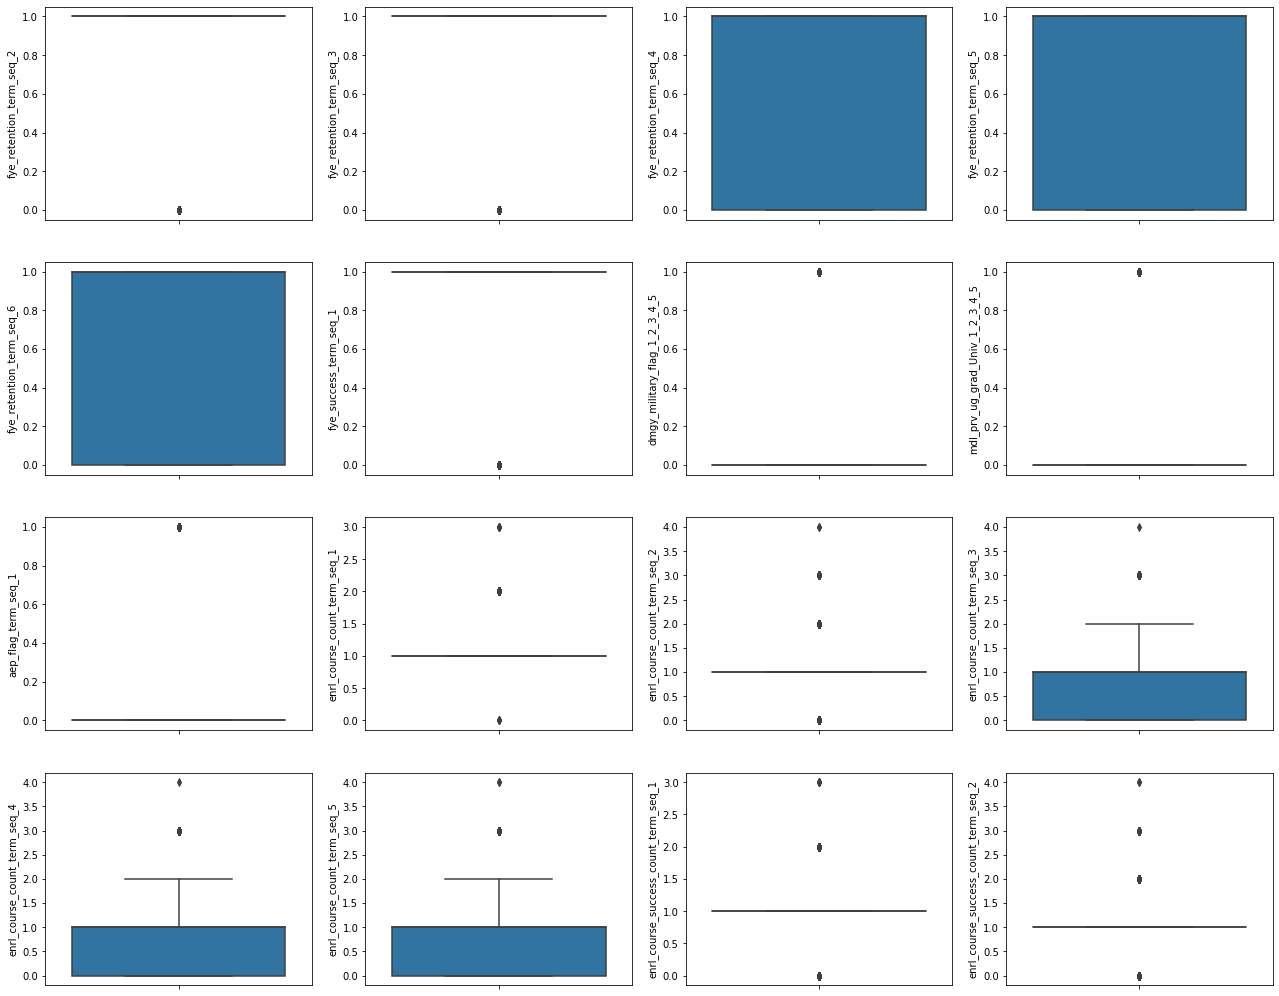

In [24]:
func_boxplot(num_cols,df_students)

#### Observations :
1. TotalVisits and Page Views per Visit have outlier.
2. They both could be highly correlated.

#### Performing statistical outlier treatment

In [25]:
# removing (statistical) outliers
Q1 = df_students['fye_retention_term_seq_2'].quantile(0.05)
Q3 = df_students['fye_retention_term_seq_2'].quantile(0.75)
IQR = Q3 - Q1
Q3 + 1.5*IQR
df_students_1 = df_students[(df_students['fye_retention_term_seq_2'] >= Q1 - 1.5*IQR) & (df_students['fye_retention_term_seq_2'] <= Q3 + 1.5*IQR)]


2.5

In [26]:
Q1 = df_students_1['fye_retention_term_seq_3'].quantile(0.05)
Q3 = df_students_1['fye_retention_term_seq_3'].quantile(0.75)
IQR = Q3 - Q1
Q3 + 1.5*IQR
df_students_1 = df_students_1[(df_students_1['fye_retention_term_seq_3'] >= Q1 - 1.5*IQR) & (df_students_1['fye_retention_term_seq_3'] <= Q3 + 1.5*IQR)]


2.5

In [27]:
Q1 = df_students_1['fye_retention_term_seq_3'].quantile(0.05)
Q3 = df_students_1['fye_retention_term_seq_3'].quantile(0.75)
IQR = Q3 - Q1
Q3 + 1.5*IQR
df_students_1 = df_students_1[(df_students_1['fye_retention_term_seq_3'] >= Q1 - 1.5*IQR) & (df_students_1['fye_retention_term_seq_3'] <= Q3 + 1.5*IQR)]


2.5

#### Converting some binary variables (Yes/No) to 0/1

In [28]:
df_students_1.nunique().sort_values()

fye_retention_term_seq_2                           2
fye_retention_term_seq_3                           2
fye_retention_term_seq_4                           2
fye_retention_term_seq_5                           2
fye_retention_term_seq_6                           2
dmgy_gender_1_2_3_4_5                              2
mdl_prv_ug_grad_Univ_1_2_3_4_5                     2
aep_flag_term_seq_1                                2
fye_success_term_seq_1                             2
dmgy_military_flag_1_2_3_4_5                       2
enrl_course_retake_count_term_seq_3                3
enrl_course_retake_count_term_seq_2                3
enrl_course_retake_count_term_seq_5                3
fye_prtcpt_in_fye_1_2_3_4_5                        3
enrl_course_retake_count_term_seq_4                3
mdl_email_domain_1_2_3_4_5                         4
enrl_course_success_count_term_seq_1               4
enrl_course_count_term_seq_1                       4
ods_cnt_programs_completed                    

In [29]:
# Applying the function to gender

df_students_1['dmgy_gender_1_2_3_4_5'] = df_students_1['dmgy_gender_1_2_3_4_5'].map({'F': 1, "M": 0})

In [30]:
df_students_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10433 entries, 0 to 10432
Columns: 177 entries, EnrollmentTerm to ods_programs_avg_gpa
dtypes: float64(123), int64(29), object(25)
memory usage: 14.2+ MB


In [31]:
df_students_1.head()

df_students_1.info()

EnrollmentTerm EnrollmentTerm_StartDate  fye_retention_term_seq_2  \
0           16T1               12/14/2015                         1   
1           15T4                7/13/2015                         1   
2           16T3                5/23/2016                         1   
3           15T5                9/28/2015                         1   
4           15T4                7/13/2015                         0   

   fye_retention_term_seq_3  fye_retention_term_seq_4  \
0                         1                         1   
1                         1                         1   
2                         1                         1   
3                         1                         1   
4                         0                         0   

   fye_retention_term_seq_5  fye_retention_term_seq_6  \
0                         1                         1   
1                         1                         1   
2                         1                         1   
3                         1                         1   
4                         0                         0   

  fye_prtcpt_in_fye_1_2_3_4_5  fye_debt_prior_Univ  fye_Univ_debt  \
0                     MISSING                    0            0.0   
1                     MISSING                    0            0.0   
2                         Yes                77800        32800.0   
3                     MISSING                    0            0.0   
4                     MISSING                    0         2908.0   

   fye_success_term_seq_1  dmgy_military_flag_1_2_3_4_5  \
0                       0                             0   
1                       1                             0   
2                       1                             0   
3                       1                             0   
4                       0                             0   

  dmgy_ethnicity_1_2_3_4_5  dmgy_gender_1_2_3_4_5 dmgy_region_1_2_3_4_5  \
0                    White                      0                   NE3   
1                    White                      0              Mountain   
2                    White                      1                   NE3   
3                    White                      1                   NE3   
4                    White                      0             Southeast   

  dmgy_state_1_2_3_4_5  dmgy_age_1_2_3_4_5 Change Major Term  \
0                   MA                  45          Not Sure   
1                   AZ                  59                 4   
2                   NH                  53          Not Sure   
3                   NH                  40          Not Sure   
4                   SC                  68          Not Sure   

   mdl_transfer_credits_1_2_3_4_5 mdl_lead_medium_type_1_2_3_4_5  \
0                               0                       pdsearch   
1                               0                        Organic   
2                               0                          Other   
3                               0                        Organic   
4                               0                          Other   

   mdl_student_famcontribution_1_2_3_4_5 mdl_prv_ug_gpa_bins_1_2_3_4_5  \
0                                    999                       Missing   
1                                    999                       Missing   
2                                   2199                       Missing   
3                                    999                       Missing   
4                                  17994                       Missing   

   mdl_prv_ug_grad_Univ_1_2_3_4_5 mdl_email_domain_1_2_3_4_5  \
0                               1                  CORPORATE   
1                               1                  CORPORATE   
2                               1                  CORPORATE   
3                               1                     OTHERS   
4                               1                  CORPORATE   

   aep_flag_term_seq_1  enrl_course_count_te

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10433 entries, 0 to 10432
Columns: 177 entries, EnrollmentTerm to ods_programs_avg_gpa
dtypes: float64(123), int64(29), object(25)
memory usage: 14.2+ MB


#### Creating dummy variables for the remaining categorical variables

In [32]:
# renaming 'Categorical Variable' to better name.
catg_cols = list(df_students_1.select_dtypes("object"))
catg_cols
num_cols = list(df_students_1.select_dtypes(exclude='object').columns)
num_cols

['EnrollmentTerm',
 'EnrollmentTerm_StartDate',
 'fye_prtcpt_in_fye_1_2_3_4_5',
 'dmgy_ethnicity_1_2_3_4_5',
 'dmgy_region_1_2_3_4_5',
 'dmgy_state_1_2_3_4_5',
 'Change Major Term',
 'mdl_lead_medium_type_1_2_3_4_5',
 'mdl_prv_ug_gpa_bins_1_2_3_4_5',
 'mdl_email_domain_1_2_3_4_5',
 'cl_avg_time_bw_cmpltd_calls_term_seq_1',
 'cl_avg_time_bw_cmpltd_calls_term_seq_2',
 'cl_avg_time_bw_cmpltd_calls_term_seq_4',
 'cl_avg_time_bw_cmpltd_calls_term_seq_5',
 'cl_gpa_bins_term_seq_1',
 'cl_gpa_bins_term_seq_2',
 'cl_gpa_bins_term_seq_3',
 'cl_gpa_bins_term_seq_4',
 'cl_gpa_bins_term_seq_5',
 'asn_avg_tot_grade_attempted_term_seq_1',
 'asn_avg_tot_grade_attempted_term_seq_2',
 'asn_avg_tot_grade_attempted_term_seq_4',
 'asn_avg_tot_grade_attempted_term_seq_5',
 'ods_last_program_gpa',
 'ods_programs_avg_gpa']

['fye_retention_term_seq_2',
 'fye_retention_term_seq_3',
 'fye_retention_term_seq_4',
 'fye_retention_term_seq_5',
 'fye_retention_term_seq_6',
 'fye_debt_prior_Univ',
 'fye_Univ_debt',
 'fye_success_term_seq_1',
 'dmgy_military_flag_1_2_3_4_5',
 'dmgy_gender_1_2_3_4_5',
 'dmgy_age_1_2_3_4_5',
 'mdl_transfer_credits_1_2_3_4_5',
 'mdl_student_famcontribution_1_2_3_4_5',
 'mdl_prv_ug_grad_Univ_1_2_3_4_5',
 'aep_flag_term_seq_1',
 'enrl_course_count_term_seq_1',
 'enrl_course_count_term_seq_2',
 'enrl_course_count_term_seq_3',
 'enrl_course_count_term_seq_4',
 'enrl_course_count_term_seq_5',
 'enrl_course_success_count_term_seq_1',
 'enrl_course_success_count_term_seq_2',
 'enrl_course_success_count_term_seq_3',
 'enrl_course_success_count_term_seq_4',
 'enrl_course_success_count_term_seq_5',
 'enrl_course_retake_count_term_seq_2',
 'enrl_course_retake_count_term_seq_3',
 'enrl_course_retake_count_term_seq_4',
 'enrl_course_retake_count_term_seq_5',
 'cl_tot_calls_term_seq_1',
 'cl_tot_c

In [33]:
## Creating Dummies from object type columns
## Will drop one encoded column to reduce multicolinearity

df_encoded = pd.get_dummies(df_students_1.select_dtypes("object"), drop_first=True)

In [34]:
## Combining encoded columns, numeric columns and  target column

students = pd.concat([df_students_1[num_cols],df_encoded], axis = 1)

In [35]:
students.shape

list(students.select_dtypes(include='object').columns)

students.head()

(10433, 10810)

[]

fye_retention_term_seq_2  fye_retention_term_seq_3  \
0                         1                         1   
1                         1                         1   
2                         1                         1   
3                         1                         1   
4                         0                         0   

   fye_retention_term_seq_4  fye_retention_term_seq_5  \
0                         1                         1   
1                         1                         1   
2                         1                         1   
3                         1                         1   
4                         0                         0   

   fye_retention_term_seq_6  fye_debt_prior_Univ  fye_Univ_debt  \
0                         1                    0            0.0   
1                         1                    0            0.0   
2                         1                77800        32800.0   
3                         1                    0            0.0   
4                         0                    0         2908.0   

   fye_success_term_seq_1  dmgy_military_flag_1_2_3_4_5  \
0                       0                             0   
1                       1                             0   
2                       1                             0   
3                       1                             0   
4                       0                             0   

   dmgy_gender_1_2_3_4_5  dmgy_age_1_2_3_4_5  mdl_transfer_credits_1_2_3_4_5  \
0                      0                  45                               0   
1                      0                  59                               0   
2                      1                  53                               0   
3                      1                  40                               0   
4                      0                  68                               0   

   mdl_student_famcontribution_1_2_3_4_5  mdl_prv_ug_grad_Univ_1_2_3_4_5  \
0                                    999                               1   
1                                    999                               1   
2                                   2199                               1   
3                                    999                               1   
4                                  17994                               1   

   aep_flag_term_seq_1  enrl_course_count_term_seq_1  \
0                    0                             1   
1                    0                             1   
2                    1                             1   
3                    0                             1   
4                    0                             1   

   enrl_course_count_term_seq_2  enrl_course_count_term_seq_3  \
0                             1                             1   
1                             1                             1   
2                             1                             1   
3                             0                             1   
4                             0                             0   

   enrl_course_count_term_seq_4  enrl_course_count_term_seq_5  \
0                             1                             1   
1                             0                             0   
2                             1                             1   
3                             1                             0   
4                             0                             0   

   enrl_course_success_count_term_seq_1  enrl_course_success_count_term_seq_2  \
0                                   0.0                                   0.0   
1                                   1.0                                   1.0   
2                                   1.0                                   1.0   
3                                   1.0                                   NaN   
4                                   0.0                                   NaN   

   enrl_course_

### Step 4: Test-Train Split

In [36]:
# Putting feature variable to X
X = students.drop(['fye_retention_term_seq_6'], axis=1)

X.head()

fye_retention_term_seq_2  fye_retention_term_seq_3  \
0                         1                         1   
1                         1                         1   
2                         1                         1   
3                         1                         1   
4                         0                         0   

   fye_retention_term_seq_4  fye_retention_term_seq_5  fye_debt_prior_Univ  \
0                         1                         1                    0   
1                         1                         1                    0   
2                         1                         1                77800   
3                         1                         1                    0   
4                         0                         0                    0   

   fye_Univ_debt  fye_success_term_seq_1  dmgy_military_flag_1_2_3_4_5  \
0            0.0                       0                             0   
1            0.0                       1                             0   
2        32800.0                       1                             0   
3            0.0                       1                             0   
4         2908.0                       0                             0   

   dmgy_gender_1_2_3_4_5  dmgy_age_1_2_3_4_5  mdl_transfer_credits_1_2_3_4_5  \
0                      0                  45                               0   
1                      0                  59                               0   
2                      1                  53                               0   
3                      1                  40                               0   
4                      0                  68                               0   

   mdl_student_famcontribution_1_2_3_4_5  mdl_prv_ug_grad_Univ_1_2_3_4_5  \
0                                    999                               1   
1                                    999                               1   
2                                   2199                               1   
3                                    999                               1   
4                                  17994                               1   

   aep_flag_term_seq_1  enrl_course_count_term_seq_1  \
0                    0                             1   
1                    0                             1   
2                    1                             1   
3                    0                             1   
4                    0                             1   

   enrl_course_count_term_seq_2  enrl_course_count_term_seq_3  \
0                             1                             1   
1                             1                             1   
2                             1                             1   
3                             0                             1   
4                             0                             0   

   enrl_course_count_term_seq_4  enrl_course_count_term_seq_5  \
0                             1                             1   
1                             0                             0   
2                             1                             1   
3                             1                             0   
4                             0                             0   

   enrl_course_success_count_term_seq_1  enrl_course_success_count_term_seq_2  \
0                                   0.0                                   0.0   
1                                   1.0                                   1.0   
2                                   1.0                                   1.0   
3                                   1.0                                   NaN   
4                                   0.0                                   NaN   

   enrl_course_success_count_term_seq_3  enrl_course_success_count_term_seq_4  \
0                                   1.0                                   1.0   
1                                   1.0 

In [37]:
# Putting response variable to y
y = students['fye_retention_term_seq_6']

y.head()

0    1
1    1
2    1
3    1
4    0
Name: fye_retention_term_seq_6, dtype: int64

In [38]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

### Step 5: Feature Scaling

In [39]:
scaler = StandardScaler()

scale_cols = ['fye_retention_term_seq_2','fye_retention_term_seq_3','fye_retention_term_seq_4','fye_retention_term_seq_5']
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])

X_train.head()

fye_retention_term_seq_2  fye_retention_term_seq_3  \
1921                 -2.790736                 -2.100866   
3854                 -2.790736                 -2.100866   
7663                 -2.790736                 -2.100866   
2917                  0.358328                  0.475994   
84                    0.358328                  0.475994   

      fye_retention_term_seq_4  fye_retention_term_seq_5  fye_debt_prior_Univ  \
1921                 -1.709423                 -1.501968                85999   
3854                 -1.709423                 -1.501968                51250   
7663                 -1.709423                 -1.501968               114213   
2917                  0.584993                  0.665793                    0   
84                    0.584993                  0.665793                    0   

      fye_Univ_debt  fye_success_term_seq_1  dmgy_military_flag_1_2_3_4_5  \
1921         2415.0                       0                             0   
3854         2584.0                       0                             1   
7663            0.0                       0                             0   
2917        49200.0                       1                             0   
84              0.0                       1                             0   

      dmgy_gender_1_2_3_4_5  dmgy_age_1_2_3_4_5  \
1921                      1                  42   
3854                      1                  67   
7663                      1                  33   
2917                      1                  37   
84                        0                  32   

      mdl_transfer_credits_1_2_3_4_5  mdl_student_famcontribution_1_2_3_4_5  \
1921                               0                                    999   
3854                               0                                  23552   
7663                               0                                    530   
2917                               0                                  31679   
84                                 0                                    999   

      mdl_prv_ug_grad_Univ_1_2_3_4_5  aep_flag_term_seq_1  \
1921                               0                    0   
3854                               0                    0   
7663                               0                    1   
2917                               0                    0   
84                                 0                    0   

      enrl_course_count_term_seq_1  enrl_course_count_term_seq_2  \
1921                             1                             0   
3854                             1                             0   
7663                             1                             0   
2917                             1                             1   
84                               1                             2   

      enrl_course_count_term_seq_3  enrl_course_count_term_seq_4  \
1921                             0                             0   
3854                             0                             0   
7663                             0                             0   
2917                             1                             1   
84                               2                             2   

      enrl_course_count_term_seq_5  enrl_course_success_count_term_seq_1  \
1921                             0                                   0.0   
3854                             0                                   0.0   
7663                             0                                   0.0   
2917                             1                                   1.0   
84                               1                                   1.0   

      enrl_course_success_count_term_seq_2  \
1921                                   NaN   
3854                                   NaN   
7663                                   NaN   
2917                                   1.0   
84                                     2.

In [40]:
### Checking the fye_retention_term_seq_6 Rate
fye_retention_term_seq_6 = (sum(students['fye_retention_term_seq_6'])/len(students['fye_retention_term_seq_6'].index))*100
fye_retention_term_seq_6

66.02127863510017

We have almost 66.0% converted rate which means

### Step 6: Model Building
Let's start by splitting our data into a training set and a test set.

#### Running Your First Training Model

In [48]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

MissingDataError: exog contains inf or nans

### Step 7: Feature Selection Using RFE

In [47]:
# running RFE with 20 variables as output
logreg = LogisticRegression()

rfe = RFE(logreg, 17)             
rfe = rfe.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [46]:
rfe.support_

AttributeError: 'RFE' object has no attribute 'support_'

In [72]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', False, 3),
 ('Do Not Call', False, 71),
 ('TotalVisits', False, 44),
 ('Total Time Spent on Website', False, 8),
 ('Page Views Per Visit', False, 43),
 ('Country', False, 28),
 ('Search', False, 87),
 ('Newspaper Article', False, 100),
 ('X Education Forums', False, 107),
 ('Newspaper', False, 101),
 ('Digital Advertisement', False, 94),
 ('Through Recommendations', False, 90),
 ('A free copy of Mastering The Interview', False, 40),
 ('Lead Origin_Landing Page Submission', False, 15),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 17),
 ('Lead Origin_Quick Add Form', False, 83),
 ('Lead Source_Google', False, 79),
 ('Lead Source_Olark Chat', False, 49),
 ('Lead Source_Organic Search', False, 54),
 ('Lead Source_Reference', False, 9),
 ('Lead Source_other', False, 35),
 ('Last Activity_Converted to Lead', False, 19),
 ('Last Activity_Email Bounced', False, 20),
 ('Last Activity_Email Link Clicked', False, 81),
 ('Last Activity_Email Marked

In [45]:
col = X_train.columns[rfe.support_]
col
len(col)

AttributeError: 'RFE' object has no attribute 'support_'

In [44]:
X_train.columns[~rfe.support_]

AttributeError: 'RFE' object has no attribute 'support_'

#### Assessing the model with StatsModels

In [43]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

NameError: name 'col' is not defined

In [76]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

8149    0.276449
7146    0.013030
7254    0.067032
3900    0.025849
6394    0.005896
1287    0.998539
1303    0.013030
5073    0.190642
4463    0.013368
6730    0.997642
dtype: float64

In [77]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.2764486 , 0.01303042, 0.06703165, 0.02584932, 0.00589603,
       0.99853908, 0.01303042, 0.19064216, 0.01336847, 0.99764197])

#### Creating a dataframe with the actual converted flag and the predicted probabilities

In [78]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final['Lead_Id'] = y_train.index
y_train_pred_final.head()

Converted  Converted_Prob  Lead_Id
0          0        0.276449     8149
1          0        0.013030     7146
2          0        0.067032     7254
3          1        0.025849     3900
4          0        0.005896     6394

#### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [79]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

Converted  Converted_Prob  Lead_Id  predicted
0          0        0.276449     8149          0
1          0        0.013030     7146          0
2          0        0.067032     7254          0
3          1        0.025849     3900          0
4          0        0.005896     6394          0

In [80]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3626  223]
 [ 193 2148]]


In [81]:
# Predicted      not_converted    converted
# Actual
# not_converted  3644             205
# converted      197              2144

In [82]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.9327948303715671


In [83]:
## We have define function for calculating VIF. Call func_VIF for repetitive use.
func_VIF(X_train[col])

Features   VIF
4                         Tags_Closed by Horizzon  1.28
6                               Tags_Lost to EINS  1.06
16  Last Notable Activity_Olark Chat Conversation  1.05
14                Asymmetrique Activity Index_Low  1.05
3                                       Tags_Busy  1.05
11                              Tags_switched off  1.03
12                        Tags_wrong number given  1.01
10                       Tags_number not provided  1.00
5                            Tags_Lateral student  1.00
0                       Lead Origin_Lead Add Form  0.65
8                                    Tags_Unknown  0.48
13                             Lead Quality_Worst  0.42
2                              Occupation_Unknown  0.10
9        Tags_Will revert after reading the email  0.07
1                          Last Activity_SMS Sent  0.04
7                                    Tags_Ringing  0.04
15                 Last Notable Activity_Modified  0.03


1. Variable with VIF >5 is problematic
2. Variable with VIF between 5 - 3 can be checked once
3. Variable with VIF <3 is good


#### Observations :
1. P-value for some variables looks high. It is best to drop those columns as they are not helping much in prediction.
2. The variable 'Tags_Lateral student' has high P-value. So let's start by dropping that.

In [84]:
col = col.drop('Tags_Lateral student', 1)
col
len(col)

Index(['Lead Origin_Lead Add Form', 'Last Activity_SMS Sent',
       'Occupation_Unknown', 'Tags_Busy', 'Tags_Closed by Horizzon',
       'Tags_Lost to EINS', 'Tags_Ringing', 'Tags_Unknown',
       'Tags_Will revert after reading the email', 'Tags_number not provided',
       'Tags_switched off', 'Tags_wrong number given', 'Lead Quality_Worst',
       'Asymmetrique Activity Index_Low', 'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation'],
      dtype='object')

16

In [85]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6190
Model:                            GLM   Df Residuals:                     6173
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1185.6
Date:                Mon, 18 Nov 2019   Deviance:                       2371.3
Time:                        22:06:50   Pearson chi2:                 8.86e+03
No. Iterations:                    23   Covariance Type:             nonrobust
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -2.7405      0.211    -13.014      0.000      -3.153      -2.328
Lead Origin_Lead Add Form                         1.0997      0.304      3.615      0.000       0.504       1.696
Last Activity_SMS Sent                            2.2029      0.124     17.779      0.000       1.960       2.446
Occupation_Unknown                               -2.6712      0.150    -17.784      0.000      -2.966      -2.377
Tags_Busy                                         2.1334      0.297      7.179      0.000       1.551       2.716
Tags_Closed by Horizzon                           8.7655      1.032      8.498      0.000       6.744      10.787
Tags_Lost to EINS                                 9.8154      0.830     11.820      0.000       8.188      11.443
Tags_Ringing                                     -2.0955      0.311     -6.734      0.000      -2.705      -1.486
Tags_Unknown                                      3.2767      0.235     13.921      0.000       2.815       3.738
Tags_Will revert after reading the email          6.0025      0.262     22.893      0.000       5.489       6.516
Tags_number not provided                        -22.6282   2.51e+04     -0.001      0.999   -4.93e+04    4.93e+04
Tags_switched off                                -2.1338      0.558     -3.827      0.000      -3.227      -1.041
Tags_wrong number given                         -22.5780      2e+04     -0.001      0.999   -3.93e+04    3.92e+04
Lead Quality_Worst                               -2.3821      0.713     -3.343      0.001      -3.779      -0.985
Asymmetrique Activity Index_Low                  -2.4707      0.448     -5.520      0.000      -3.348      -1.593
Last Notable Activity_Modified                   -1.4929      0.125    -11.912      0.000      -1.739      -1.247
Last Notable Activity_Olark Chat Conversation    -1.4741      0.452     -3.261      0.001      -2.360      -0.588
=================================================================================================================
"""

#### Observations :
1. P-value for 'Tags_number not provided' and 'Tags_wrong number given' are still same as high.

In [86]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred[:10]

array([0.27754984, 0.01429611, 0.06704063, 0.02588534, 0.00592541,
       0.9985927 , 0.01429611, 0.19388825, 0.01456343, 0.99758841])

In [87]:
y_train_pred_final['Converted_Prob'] = y_train_pred

In [88]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Converted  Converted_Prob  Lead_Id  predicted
0          0        0.277550     8149          0
1          0        0.014296     7146          0
2          0        0.067041     7254          0
3          1        0.025885     3900          0
4          0        0.005925     6394          0

In [89]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.9324717285945072


In [90]:
## We have define function for calculating VIF. Call func_VIF for repetitive use.
func_VIF(X_train[col])

Features   VIF
4                         Tags_Closed by Horizzon  1.28
5                               Tags_Lost to EINS  1.06
3                                       Tags_Busy  1.05
13                Asymmetrique Activity Index_Low  1.05
15  Last Notable Activity_Olark Chat Conversation  1.05
10                              Tags_switched off  1.03
11                        Tags_wrong number given  1.01
9                        Tags_number not provided  1.00
0                       Lead Origin_Lead Add Form  0.65
7                                    Tags_Unknown  0.48
12                             Lead Quality_Worst  0.42
2                              Occupation_Unknown  0.10
8        Tags_Will revert after reading the email  0.07
1                          Last Activity_SMS Sent  0.04
6                                    Tags_Ringing  0.04
14                 Last Notable Activity_Modified  0.03

#### Lets drop now 'Tags_number not provided'

In [91]:
col = col.drop('Tags_number not provided', 1)
col
len(col)

Index(['Lead Origin_Lead Add Form', 'Last Activity_SMS Sent',
       'Occupation_Unknown', 'Tags_Busy', 'Tags_Closed by Horizzon',
       'Tags_Lost to EINS', 'Tags_Ringing', 'Tags_Unknown',
       'Tags_Will revert after reading the email', 'Tags_switched off',
       'Tags_wrong number given', 'Lead Quality_Worst',
       'Asymmetrique Activity Index_Low', 'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation'],
      dtype='object')

15

In [92]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6190
Model:                            GLM   Df Residuals:                     6174
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1188.6
Date:                Mon, 18 Nov 2019   Deviance:                       2377.3
Time:                        22:06:51   Pearson chi2:                 8.78e+03
No. Iterations:                    22   Covariance Type:             nonrobust
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -2.8387      0.211    -13.450      0.000      -3.252      -2.425
Lead Origin_Lead Add Form                         1.1044      0.304      3.628      0.000       0.508       1.701
Last Activity_SMS Sent                            2.1848      0.123     17.713      0.000       1.943       2.427
Occupation_Unknown                               -2.6647      0.150    -17.786      0.000      -2.958      -2.371
Tags_Busy                                         2.2396      0.296      7.560      0.000       1.659       2.820
Tags_Closed by Horizzon                           8.8521      1.032      8.579      0.000       6.830      10.875
Tags_Lost to EINS                                 9.8902      0.831     11.905      0.000       8.262      11.519
Tags_Ringing                                     -1.9830      0.310     -6.401      0.000      -2.590      -1.376
Tags_Unknown                                      3.3739      0.236     14.310      0.000       2.912       3.836
Tags_Will revert after reading the email          6.0956      0.263     23.183      0.000       5.580       6.611
Tags_switched off                                -2.0205      0.557     -3.629      0.000      -3.112      -0.929
Tags_wrong number given                         -21.4702   1.22e+04     -0.002      0.999   -2.39e+04    2.38e+04
Lead Quality_Worst                               -2.3024      0.717     -3.211      0.001      -3.708      -0.897
Asymmetrique Activity Index_Low                  -2.4635      0.448     -5.503      0.000      -3.341      -1.586
Last Notable Activity_Modified                   -1.4808      0.125    -11.825      0.000      -1.726      -1.235
Last Notable Activity_Olark Chat Conversation    -1.4712      0.452     -3.254      0.001      -2.357      -0.585
=================================================================================================================
"""

In [93]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred[:10]

y_train_pred_final['Converted_Prob'] = y_train_pred


array([0.2797669 , 0.01313152, 0.06680198, 0.02633086, 0.00581734,
       0.99856645, 0.01313152, 0.19379832, 0.01325692, 0.99756021])

In [94]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()


Converted  Converted_Prob  Lead_Id  predicted
0          0        0.279767     8149          0
1          0        0.013132     7146          0
2          0        0.066802     7254          0
3          1        0.026331     3900          0
4          0        0.005817     6394          0

In [95]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))


0.9324717285945072


In [96]:
## We have define function for calculating VIF. Call func_VIF for repetitive use.
func_VIF(X_train[col])

Features   VIF
4                         Tags_Closed by Horizzon  1.28
5                               Tags_Lost to EINS  1.06
3                                       Tags_Busy  1.05
12                Asymmetrique Activity Index_Low  1.05
14  Last Notable Activity_Olark Chat Conversation  1.05
9                               Tags_switched off  1.03
10                        Tags_wrong number given  1.01
0                       Lead Origin_Lead Add Form  0.65
7                                    Tags_Unknown  0.48
11                             Lead Quality_Worst  0.42
2                              Occupation_Unknown  0.10
8        Tags_Will revert after reading the email  0.07
1                          Last Activity_SMS Sent  0.04
6                                    Tags_Ringing  0.04
13                 Last Notable Activity_Modified  0.03

#### Let's drop 'Tags_wrong number given' as P-value for this high

In [97]:
col = col.drop('Tags_wrong number given', 1)
col
len(col)

Index(['Lead Origin_Lead Add Form', 'Last Activity_SMS Sent',
       'Occupation_Unknown', 'Tags_Busy', 'Tags_Closed by Horizzon',
       'Tags_Lost to EINS', 'Tags_Ringing', 'Tags_Unknown',
       'Tags_Will revert after reading the email', 'Tags_switched off',
       'Lead Quality_Worst', 'Asymmetrique Activity Index_Low',
       'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation'],
      dtype='object')

14

In [98]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6190
Model:                            GLM   Df Residuals:                     6175
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1192.8
Date:                Mon, 18 Nov 2019   Deviance:                       2385.5
Time:                        22:06:52   Pearson chi2:                 8.73e+03
No. Iterations:                     8   Covariance Type:             nonrobust
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -2.9709      0.211    -14.048      0.000      -3.385      -2.556
Lead Origin_Lead Add Form                         1.1111      0.305      3.645      0.000       0.514       1.709
Last Activity_SMS Sent                            2.1618      0.123     17.618      0.000       1.921       2.402
Occupation_Unknown                               -2.6566      0.149    -17.785      0.000      -2.949      -2.364
Tags_Busy                                         2.3828      0.295      8.080      0.000       1.805       2.961
Tags_Closed by Horizzon                           8.9729      1.032      8.693      0.000       6.950      10.996
Tags_Lost to EINS                                10.0011      0.831     12.036      0.000       8.372      11.630
Tags_Ringing                                     -1.8325      0.308     -5.951      0.000      -2.436      -1.229
Tags_Unknown                                      3.5061      0.236     14.858      0.000       3.044       3.969
Tags_Will revert after reading the email          6.2238      0.264     23.615      0.000       5.707       6.740
Tags_switched off                                -1.8686      0.556     -3.364      0.001      -2.957      -0.780
Lead Quality_Worst                               -2.2585      0.720     -3.139      0.002      -3.669      -0.848
Asymmetrique Activity Index_Low                  -2.4554      0.448     -5.483      0.000      -3.333      -1.578
Last Notable Activity_Modified                   -1.4698      0.125    -11.746      0.000      -1.715      -1.225
Last Notable Activity_Olark Chat Conversation    -1.4690      0.452     -3.248      0.001      -2.355      -0.583
=================================================================================================================
"""

In [99]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred[:10]

array([0.28199218, 0.01165036, 0.06650345, 0.0268269 , 0.005328  ,
       0.99853692, 0.01165036, 0.19319301, 0.0116596 , 0.99753211])

In [100]:
y_train_pred_final['Converted_Prob'] = y_train_pred

In [101]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Converted  Converted_Prob  Lead_Id  predicted
0          0        0.281992     8149          0
1          0        0.011650     7146          0
2          0        0.066503     7254          0
3          1        0.026827     3900          0
4          0        0.005328     6394          0

In [102]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3626  223]
 [ 195 2146]]


In [103]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))


0.9324717285945072


In [104]:
## We have define function for calculating VIF. Call func_VIF for repetitive use.
func_VIF(X_train[col])

Features   VIF
4                         Tags_Closed by Horizzon  1.28
5                               Tags_Lost to EINS  1.06
3                                       Tags_Busy  1.05
11                Asymmetrique Activity Index_Low  1.05
13  Last Notable Activity_Olark Chat Conversation  1.05
9                               Tags_switched off  1.03
0                       Lead Origin_Lead Add Form  0.65
7                                    Tags_Unknown  0.48
10                             Lead Quality_Worst  0.42
2                              Occupation_Unknown  0.10
8        Tags_Will revert after reading the email  0.07
1                          Last Activity_SMS Sent  0.04
6                                    Tags_Ringing  0.04
12                 Last Notable Activity_Modified  0.03

<Figure size 1200x640 with 0 Axes>

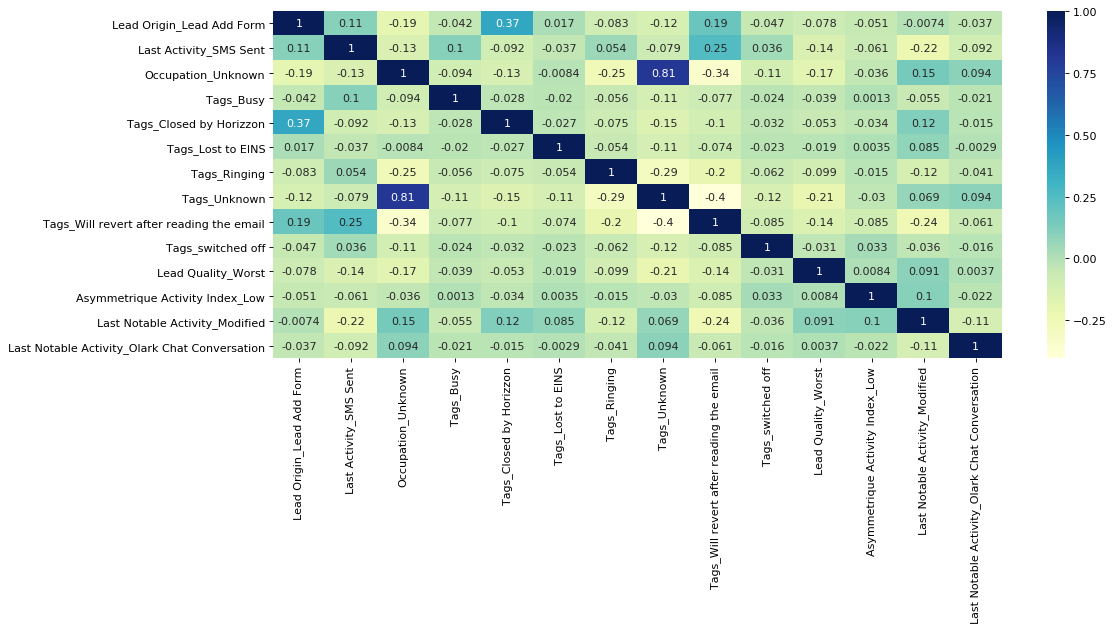

In [105]:
plt.figure(figsize=(15,8), dpi=80, facecolor='w', edgecolor='k', frameon='True')

cor = X_train[col].corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu")

plt.tight_layout()
plt.show()

### Our latest model have the following features:
1. All variables have p-value < 0.05.
2. All the features have very low VIF values, meaning, there is hardly any muliticollinearity among the features. 
   WE can see same in Heatmap.
3. The overall accuracy of 93% at a probability threshold of 0.05.


#### we can proceed with making predictions using this model only.

### Step 8: Metrics beyond simply accuracy

In [106]:

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [107]:
# Let's see the sensitivity of our logistic regression model 
# sensitivity = Total Number of Actual Yes perdicted correctly / Total Number of Actual Yes

TP / float(TP+FN)


0.916702263989748

In [108]:
# Let us calculate specificity
# specificity = Total Number of Actual No perdicted correctly / Total Number of Actual No

TN / float(TN+FP)

0.9420628734736295

#### Observations:
1. Sensitivity and Specificity have more than 90% which is good.

In [109]:
# Calculate false postive rate - predicting Converted when customer does not have converted
print(FP/ float(TN+FP))

0.05793712652637049


In [110]:
# positive predictive value 
print (TP / float(TP+FP))

0.9058674546222034


In [111]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9489662392043967


#### With overall numbers, model looks good.

### Step 9: Plotting the ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [112]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [113]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Converted_Prob, drop_intermediate = False )

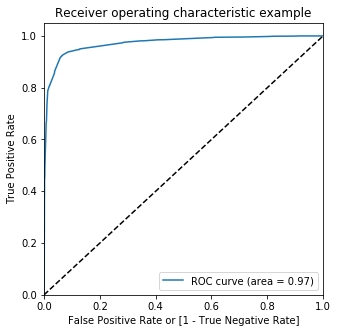

In [114]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

In [115]:
### Calculating the area under the curve

auc = func_auc(fpr,tpr)
auc

0.9722036235688798

### Step 10: Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [116]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted  Converted_Prob  Lead_Id  predicted  0.0  0.1  0.2  0.3  0.4  \
0          0        0.281992     8149          0    1    1    1    0    0   
1          0        0.011650     7146          0    1    0    0    0    0   
2          0        0.066503     7254          0    1    0    0    0    0   
3          1        0.026827     3900          0    1    0    0    0    0   
4          0        0.005328     6394          0    1    0    0    0    0   

   0.5  0.6  0.7  0.8  0.9  
0    0    0    0    0    0  
1    0    0    0    0    0  
2    0    0    0    0    0  
3    0    0    0    0    0  
4    0    0    0    0    0

In [117]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.378191  1.000000  0.000000
0.1   0.1  0.816317  0.973088  0.720966
0.2   0.2  0.922940  0.938061  0.913744
0.3   0.3  0.929402  0.929090  0.929592
0.4   0.4  0.932310  0.916702  0.941803
0.5   0.5  0.932472  0.916702  0.942063
0.6   0.6  0.922617  0.856472  0.962847
0.7   0.7  0.914701  0.807774  0.979735
0.8   0.8  0.915024  0.806066  0.981294
0.9   0.9  0.891599  0.730030  0.989867


### Let's plot accuracy sensitivity and specificity for various probabilities.


([<matplotlib.axis.XTick at 0x268e73b6c18>,
 <a list of 20 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x268e65cda58>,
 <a list of 10 Text yticklabel objects>)

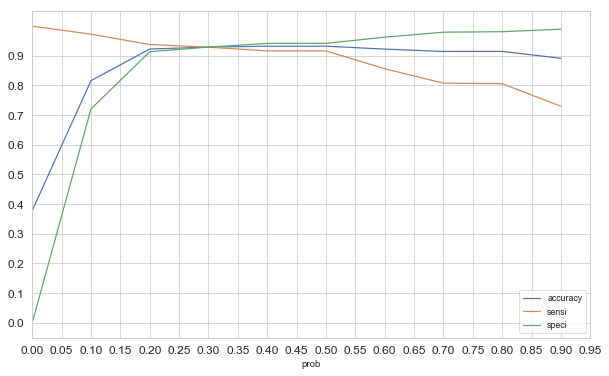

In [118]:

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], figsize=(10,6))
plt.xticks(np.arange(0, 1, step=0.05), size = 12)
plt.yticks(np.arange(0, 1, step=0.1), size = 12)
plt.show()

#### From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

In [119]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

Converted  Converted_Prob  Lead_Id  predicted  0.0  0.1  0.2  0.3  0.4  \
0          0        0.281992     8149          0    1    1    1    0    0   
1          0        0.011650     7146          0    1    0    0    0    0   
2          0        0.066503     7254          0    1    0    0    0    0   
3          1        0.026827     3900          0    1    0    0    0    0   
4          0        0.005328     6394          0    1    0    0    0    0   

   0.5  0.6  0.7  0.8  0.9  final_predicted  
0    0    0    0    0    0                0  
1    0    0    0    0    0                0  
2    0    0    0    0    0                0  
3    0    0    0    0    0                0  
4    0    0    0    0    0                0

In [120]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.9294022617124394

In [121]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[3578,  271],
       [ 166, 2175]], dtype=int64)

### Let's check metrics again after new probability cutoff

In [122]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [123]:
# Let's see the sensitivity of our logistic regression model 
# sensitivity = Total Number of Actual Yes perdicted correctly / Total Number of Actual Yes

TP / float(TP+FN)


0.9290901324220419

In [124]:
# Let us calculate specificity
# specificity = Total Number of Actual No perdicted correctly / Total Number of Actual No

TN / float(TN+FP)

0.9295921018446349

#### Observations:
1. Sensitivity and Specificity have more than 90% which is good.

In [125]:
# Calculate false postive rate - predicting Converted when customer does not have converted
print(FP/ float(TN+FP))

0.07040789815536502


In [126]:
# positive predictive value 
print (TP / float(TP+FP))

0.8892068683565004


In [127]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9556623931623932


### Step 11: Precision and Recall

#### Precision
- TP / TP + FP

In [128]:
confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.9058674546222034

#### Recall
- TP / TP + FN

In [129]:
confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.916702263989748

In [130]:
# Precision 
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.9058674546222034

In [131]:
# Recall
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.916702263989748

### Precision and recall tradeoff

In [132]:
y_train_pred_final.Converted, y_train_pred_final.final_predicted



(0       0
 1       0
 2       0
 3       1
 4       0
 5       1
 6       0
 7       0
 8       0
 9       1
 10      0
 11      0
 12      0
 13      1
 14      1
 15      0
 16      0
 17      0
 18      0
 19      0
 20      0
 21      0
 22      1
 23      0
 24      0
 25      1
 26      1
 27      0
 28      0
 29      0
 30      0
 31      0
 32      1
 33      0
 34      1
 35      1
 36      0
 37      0
 38      1
 39      0
 40      0
 41      1
 42      0
 43      1
 44      0
 45      1
 46      0
 47      1
 48      1
 49      0
 50      0
 51      1
 52      0
 53      0
 54      1
 55      1
 56      0
 57      0
 58      1
 59      0
 60      1
 61      0
 62      1
 63      1
 64      1
 65      1
 66      0
 67      1
 68      0
 69      1
 70      1
 71      0
 72      0
 73      0
 74      1
 75      0
 76      1
 77      1
 78      1
 79      1
 80      1
 81      0
 82      1
 83      0
 84      1
 85      1
 86      0
 87      1
 88      0
 89      1
 90      0

In [133]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

<Figure size 720x432 with 0 Axes>

([<matplotlib.axis.XTick at 0x268e7279c18>,
 <a list of 20 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x268e72435f8>,
 <a list of 10 Text yticklabel objects>)

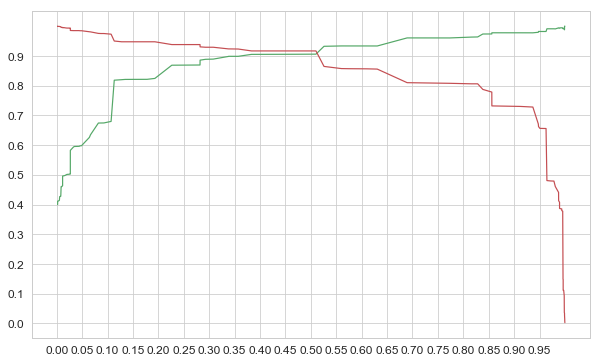

In [134]:



sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")
plt.figure(figsize=(10, 6))
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.xticks(np.arange(0, 1, step=0.05), size = 12)
plt.yticks(np.arange(0, 1, step=0.1), size = 12)
plt.show()

### Step 11: Making predictions on the test set

In [135]:
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

In [136]:
X_test = X_test[col]
X_test.head()

Lead Origin_Lead Add Form  Last Activity_SMS Sent  Occupation_Unknown  \
2924                          1                       0                   0   
3763                          0                       1                   0   
2015                          0                       1                   0   
4910                          0                       0                   1   
8719                          0                       0                   0   

      Tags_Busy  Tags_Closed by Horizzon  Tags_Lost to EINS  Tags_Ringing  \
2924          0                        1                  0             0   
3763          0                        0                  0             0   
2015          0                        0                  0             0   
4910          0                        0                  0             0   
8719          0                        0                  0             0   

      Tags_Unknown  Tags_Will revert after reading the email  \
2924             0                                         0   
3763             0                                         1   
2015             0                                         1   
4910             1                                         0   
8719             0                                         1   

      Tags_switched off  Lead Quality_Worst  Asymmetrique Activity Index_Low  \
2924                  0                   0                                0   
3763                  0                   0                                0   
2015                  0                   0                                0   
4910                  0                   0                                0   
8719                  0                   0                                0   

      Last Notable Activity_Modified  \
2924                               1   
3763                               0   
2015                               0   
4910                               0   
8719                               1   

      Last Notable Activity_Olark Chat Conversation  
2924                                              0  
3763                                              0  
2015                                              0  
4910                                              0  
8719                                              0

In [137]:
X_test_sm = sm.add_constant(X_test)

#### Making predictions on test

In [138]:
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]

2924    0.996471
3763    0.995569
2015    0.995569
4910    0.107035
8719    0.856082
7827    0.026827
8889    0.981014
1485    0.107035
475     0.999709
8000    0.000460
dtype: float64

In [139]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

# Let's see the head
y_pred_1.head()

0
2924  0.996471
3763  0.995569
2015  0.995569
4910  0.107035
8719  0.856082

In [140]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

# Putting Lead_Id to index
y_test_df['Lead_Id'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)


# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

y_pred_final.head()

Converted  Lead_Id         0
0          1     2924  0.996471
1          1     3763  0.995569
2          1     2015  0.995569
3          0     4910  0.107035
4          1     8719  0.856082

In [141]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Prob'})

# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['Lead_Id','Converted','Converted_Prob'], axis=1)

# Let's see the head of y_pred_final
y_pred_final.head()

Lead_Id  Converted  Converted_Prob
0     2924          1        0.996471
1     3763          1        0.995569
2     2015          1        0.995569
3     4910          0        0.107035
4     8719          1        0.856082

In [142]:
y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.51 else 0)

In [143]:
y_pred_final.head()

Lead_Id  Converted  Converted_Prob  final_predicted
0     2924          1        0.996471                1
1     3763          1        0.995569                1
2     2015          1        0.995569                1
3     4910          0        0.107035                0
4     8719          1        0.856082                1

In [144]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.9351921627731725

In [145]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion2

array([[1514,   88],
       [  84,  968]], dtype=int64)

In [146]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [147]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.9201520912547528

In [148]:
# Let us calculate specificity
TN / float(TN+FP)

0.9450686641697877

In [149]:
# Calculate false postive rate - predicting Converted when customer does not have converted
print(FP/ float(TN+FP))

# positive predictive value 
print (TP / float(TP+FP))

# Negative predictive value
print (TN / float(TN+ FN))

0.05493133583021224
0.9166666666666666
0.9474342928660826


In [150]:
# Precision 
TP / float(TP + FP)

0.9166666666666666

In [151]:
# Recall
TP / float(TP + FN)

0.9201520912547528

### Classification Report

In [152]:
print(classification_report(y_pred_final.Converted, y_pred_final.final_predicted))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1602
           1       0.92      0.92      0.92      1052

   micro avg       0.94      0.94      0.94      2654
   macro avg       0.93      0.93      0.93      2654
weighted avg       0.94      0.94      0.94      2654



### ROC curve for Test Data

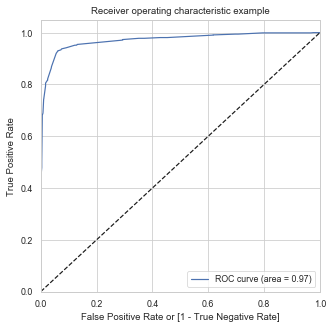

In [153]:
fpr, tpr, thresholds = metrics.roc_curve( y_pred_final.Converted, y_pred_final.Converted_Prob, drop_intermediate = False )

draw_roc(y_pred_final.Converted, y_pred_final.Converted_Prob)

### Gini coefficient = Area under ROC curve

In [154]:
### Calculating the area under the curve

auc = func_auc(fpr,tpr)
auc

0.9711707798711691

### Step 13: Calculating Lead score for the entire dataset

<font color = green> Lead Score = 100 * Converted_Probability <br> </font>
<font color = green> This needs to be calculated for all the leads from the original dataset (train + test) </font>

In [155]:
# Concatenating the 2 dataframes train and test along the rows with the append() function
final_col = ['Lead_Id','Converted','Converted_Prob','final_predicted']

final_lead = y_train_pred_final[final_col].append(y_pred_final[final_col])
final_lead.head()

Lead_Id  Converted  Converted_Prob  final_predicted
0     8149          0        0.281992                0
1     7146          0        0.011650                0
2     7254          0        0.066503                0
3     3900          1        0.026827                0
4     6394          0        0.005328                0

In [156]:
len(y_train_pred_final)
len(y_pred_final)
len(final_lead)

6190

2654

8844

In [157]:
len(final_lead['Lead_Id'].unique().tolist())

8844

In [158]:

# Calculating the Lead Score value
# Lead Score = 100 * Conversion_Prob
final_lead['Lead_Score'] = final_lead['Converted_Prob'].apply(lambda x : round(x*100))
final_lead.head()

Lead_Id  Converted  Converted_Prob  final_predicted  Lead_Score
0     8149          0        0.281992                0          28
1     7146          0        0.011650                0           1
2     7254          0        0.066503                0           7
3     3900          1        0.026827                0           3
4     6394          0        0.005328                0           1

In [159]:
## Concat Lead number from original df to final df. 

final_lead = final_lead.set_index('Lead_Id').sort_index(axis = 0, ascending = True)

print("Final size :",final_lead.shape)
print("Original size :",original_lead_num.shape)


Final size : (8844, 4)
Original size : (8844, 1)


In [160]:
final_lead = pd.concat([original_lead_num, final_lead], axis=1)
final_lead.head(5)

Lead Number  Converted  Converted_Prob  final_predicted  Lead_Score
0       660737          0        0.011650                0           1
1       660728          0        0.008135                0           1
2       660727          1        0.962777                1          96
3       660719          0        0.001883                0           0
4       660681          1        0.856082                1          86

In [161]:
final_lead.shape

(8844, 5)

In [162]:
final_lead.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8844 entries, 0 to 9239
Data columns (total 5 columns):
Lead Number        8844 non-null int64
Converted          8844 non-null int64
Converted_Prob     8844 non-null float64
final_predicted    8844 non-null int64
Lead_Score         8844 non-null int64
dtypes: float64(1), int64(4)
memory usage: 414.6 KB


### Step 14: Determining Feature Importance

In [163]:
pd.options.display.float_format = '{:.2f}'.format
coef = res.params[1:]
coef

Lead Origin_Lead Add Form                        1.11
Last Activity_SMS Sent                           2.16
Occupation_Unknown                              -2.66
Tags_Busy                                        2.38
Tags_Closed by Horizzon                          8.97
Tags_Lost to EINS                               10.00
Tags_Ringing                                    -1.83
Tags_Unknown                                     3.51
Tags_Will revert after reading the email         6.22
Tags_switched off                               -1.87
Lead Quality_Worst                              -2.26
Asymmetrique Activity Index_Low                 -2.46
Last Notable Activity_Modified                  -1.47
Last Notable Activity_Olark Chat Conversation   -1.47
dtype: float64

#### Getting a relative coeffient value for all the features wrt the feature with the highest coefficient

In [164]:
features = coef
features = 100.0 * (coef / coef.max())
features

Lead Origin_Lead Add Form                        11.11
Last Activity_SMS Sent                           21.62
Occupation_Unknown                              -26.56
Tags_Busy                                        23.83
Tags_Closed by Horizzon                          89.72
Tags_Lost to EINS                               100.00
Tags_Ringing                                    -18.32
Tags_Unknown                                     35.06
Tags_Will revert after reading the email         62.23
Tags_switched off                               -18.68
Lead Quality_Worst                              -22.58
Asymmetrique Activity Index_Low                 -24.55
Last Notable Activity_Modified                  -14.70
Last Notable Activity_Olark Chat Conversation   -14.69
dtype: float64

In [165]:

sorted_feature = np.argsort(features,kind='quicksort')
sorted_feature

Lead Origin_Lead Add Form                         2
Last Activity_SMS Sent                           11
Occupation_Unknown                               10
Tags_Busy                                         9
Tags_Closed by Horizzon                           6
Tags_Lost to EINS                                12
Tags_Ringing                                     13
Tags_Unknown                                      0
Tags_Will revert after reading the email          1
Tags_switched off                                 3
Lead Quality_Worst                                7
Asymmetrique Activity Index_Low                   8
Last Notable Activity_Modified                    4
Last Notable Activity_Olark Chat Conversation     5
dtype: int64

#### Plot showing the feature variables based on their relative coefficient values

<BarContainer object of 14 artists>

[Text(0, 0, 'Occupation_Unknown'),
 Text(0, 0, 'Asymmetrique Activity Index_Low'),
 Text(0, 0, 'Lead Quality_Worst'),
 Text(0, 0, 'Tags_switched off'),
 Text(0, 0, 'Tags_Ringing'),
 Text(0, 0, 'Last Notable Activity_Modified'),
 Text(0, 0, 'Last Notable Activity_Olark Chat Conversation'),
 Text(0, 0, 'Lead Origin_Lead Add Form'),
 Text(0, 0, 'Last Activity_SMS Sent'),
 Text(0, 0, 'Tags_Busy'),
 Text(0, 0, 'Tags_Unknown'),
 Text(0, 0, 'Tags_Will revert after reading the email'),
 Text(0, 0, 'Tags_Closed by Horizzon'),
 Text(0, 0, 'Tags_Lost to EINS')]

Text(0.5, 0, 'Relative Feature Importance')

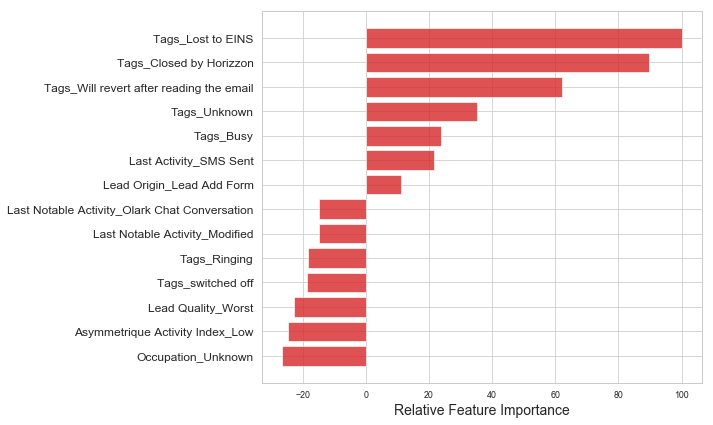

In [166]:
pos = np.arange(sorted_feature.shape[0]) + .5

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
ax.barh(pos, features[sorted_feature], align='center', color = 'tab:red',alpha=0.8)
ax.set_yticks(pos)
ax.set_yticklabels(np.array(X_train[col].columns)[sorted_feature], fontsize=12)
ax.set_xlabel('Relative Feature Importance', fontsize=14)

plt.tight_layout()   
plt.show()


### Selecting Top 3 features which contribute most towards the probability of a lead getting converted

In [167]:
pd.DataFrame(features).reset_index().sort_values(by=0,ascending=False).head(3)

index      0
5                         Tags_Lost to EINS 100.00
4                   Tags_Closed by Horizzon  89.72
8  Tags_Will revert after reading the email  62.23